# SARIMA Model - Predicting Google Mobility Index

This notebook demonstrates how I developed the SARIMA model for predicting google mobility index in each county and made a forecast for the year of 2022. Please read my data cleaning notebook for data cleaning, descriptive statistics, and EDA. 

Contents of this notebook: 
1. Dickey-Fuller Test 

2. Modeling (Grid Search)

3. Model Validation 

3. Forecasting


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import itertools
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

First, I read the data frame and I change the date to the datetime format and set date and zip code in indexes. 

In [2]:
# read data 
DF = pd.read_csv('Data/mobility.csv')

# set date into datetime frame
DF.date = pd.to_datetime(DF.date)


# set date and countyfips as index 
DF = DF.set_index(['countyfips', 'date']).sort_index() 

DF

commercial  new_case_count
countyfips date                                  
11001      2020-02-24      -221.5             0.0
           2020-02-25      -193.0             0.0
           2020-02-26       164.0             0.0
           2020-02-27      -128.5             0.0
           2020-02-28       -28.5             0.0
...                           ...             ...
51683      2022-01-05       -51.0            92.0
           2022-01-06       291.5            88.0
           2022-01-07      -420.0            89.0
           2022-01-08      -224.5            89.0
           2022-01-09      -331.0            89.0

[10936 rows x 2 columns]

In [3]:
print('Mobility data covers from', DF.index.unique(level='date').min(), 'to' , DF.index.unique(level='date').max())
print('It includes', len(DF.index.unique(level='countyfips')), 'counties in Washington DC metro area.' )

Mobility data covers from 2020-02-24 00:00:00 to 2022-01-09 00:00:00
It includes 16 counties in Washington DC metro area.


Before start analysis, I split my data set into train and test set. I use the 2021-11-01 as a cutoff date. As a consequence, train set has 47 observation and test set has 7 observations.

In [4]:
# use 2021-11-01 as the cutoff point 
train = DF[DF.index.get_level_values('date') < '2021-11-01']

test = DF[DF.index.get_level_values('date') >= '2021-11-01']


In [5]:
print('Number of observation in train set:', len(train.index.unique(level='date')))
print('Number of observation in test set for each county:', len(test.index.unique(level='date')))

Number of observation in train set: 616
Number of observation in test set for each county: 70


# 1. Dickey-Fuller Test
I performed the Dickey-Fuller test for stationarity check of a time series. 
Below, I conducted the ADFuller test three times. The first test was with an original time series (i.e., no differencing, no moving average). And if a county fails this first test, I take a difference of a time series and redo the Dickey-Fuller test. If failed again, I take the second difference and try the ADFuller test. And any counties which failed the test with a second difference were dropped from this analysis. 

To run the test throughout all counties in my sample, first, I run the test and store the result in the data frame. And then, I evaluate the p-value and filter the zip code that failed the test. Zip codes that passed the first test are stored in 'diff0' list. Zip codes which need a second test with difference terms, I stored in 'diff1'.


In [6]:
# Check Dickey-Fuller test and report the p-values for each series

# To store the test result from each county
dtest = pd.DataFrame()
df_p = [] 
Fips = []

fips = train.index.unique(level='countyfips')
for x in fips:
    p_val_1 = adfuller(train.loc[(x, ),]['commercial'])[1] # extract p-value
    df_p.append(p_val_1)
    Fips.append(x) 
    
dtest['countyfips'] = Fips
dtest['Dickey_Fuller_p'] = df_p


dtest.head()

,countyfips,Dickey_Fuller_p
0,11001,0.000077
1,24009,0.000002
2,24017,0.000016
3,24021,0.012159
4,24031,0.123620


The cell below filters out the zip codes by p-value. If it's smaller than 0.05, the zipcode is stored in 'diff0'. If it's larger than 0.05, the zipcode is sotred in 'diff1'.

In [7]:
# Create a list of county IDs (conutyfips) which passed the test as well as which did not pass the test. 

#List of zipcode which pass Dickey-Fuller test without taking difference 
diff0 = list(dtest[dtest.Dickey_Fuller_p <=0.05].countyfips)

# List a zipcode which failed Dickey-Fuller test, thus need to take difference
diff1 = list(dtest[dtest.Dickey_Fuller_p > 0.05].countyfips)


print(f'{len(diff0)} counties pass. {len(diff1)} counties does not pass the test, so redo the test after taking a difference.' )



13 counties pass. 3 counties does not pass the test, so redo the test after taking a difference.


For zip codes which failed the first dickey fuller test, I take a difference and redo the test. 

In [8]:
# Check Dickey-Fuller test and report the p-values for each county
# To store the test result from each county
dtest = pd.DataFrame()
df_p = [] 
Fips = []

# now I do test only for the counties which failed the earlier test 
fips = diff1
for x in diff1:
    p_val_1 = adfuller(train.diff().dropna().loc[(x, ),]['commercial'])[1] # extract p-value
    df_p.append(p_val_1)
    Fips.append(x) 
    
dtest['countyfips'] = Fips
dtest['Dickey_Fuller_p'] = df_p


dtest.head()

,countyfips,Dickey_Fuller_p
0,24031,7.551675e-28
1,51061,6.311724e-22
2,51610,6.672876e-17


In below, I filter the zip codes which failed the second DF test.

In [9]:
# Create a list of counties which passed the test as well as which did not pass the test. 

#List of zipcode which pass Dickey-Fuller test without taking difference 
diff1_1 = list(dtest[dtest.Dickey_Fuller_p <=0.05].countyfips)

# List a zipcode which failed Dickey-Fuller test, thus need to take difference
diff2 = list(dtest[dtest.Dickey_Fuller_p > 0.05].countyfips)


print(f'{len(diff1_1)} counties passed the test after differencing. {len(diff2)} counties does not pass the test.' )



3 counties passed the test after differencing. 0 counties does not pass the test.


Now, all counties passed the Dickey-Fuller stationary test with original series or one-time differenced series. 
Next, I start modeling.  


# 2. Modeling
## Rationality of using SARIMAX (seasonal ARIMA with exogenous variable)
I chose SARIMAX model with the COVID-19 daily new cases as exogenous variable. As shows in EDA section, the google mobility data is clearly influenced by the spread of COVID-19 cases in a region. So I picked SARIMAX model with the COVID-19 daily cases as exogenous variable.

### Pre-processing to train the model individually for each county

I train a model for each county individually. To streamline the modeling process, I create a list of a data frame. Each data frame is for one county. In this way, I can use for loop to run grid search, model validation, and forecasting for allcounties at once. I separate a list of a data frame by how many times I took the difference of a time series. Counties that passed the DF test without differencing, I stored in (diff0). Counties that took the first difference are in (diff1), and counties that took two times are in (diff2). This grouping helps me later when I roll back the differenced time series.

In [10]:
# Make a list of data frame for each county which takes original scale  
# To store the data frame for train set, test set, and total periods. 

train_diff0 = []
test_diff0 = []
all_diff0 = []

# Split the data by county and store in a list 
for x in diff0:
    train_diff0.append(pd.DataFrame(train.loc[(x, ),]))
    test_diff0.append(pd.DataFrame(test.loc[(x, ),]))
    all_diff0.append(pd.DataFrame(DF.loc[(x, ),]))


In [11]:
# Make a list of data frame for each county which takes a difference 
# To store original data frame (no differencing)  
train_orig1 = []
test_orig1 = []
all_orig1 = []
# To store differenced data frame
train_diff1 = []
test_diff1 = []
all_diff1 = []


for x in diff1_1:
    train_orig1.append(pd.DataFrame(train.loc[(x, ),]))
    test_orig1.append(pd.DataFrame(test.loc[(x, ),]))
    all_orig1.append(pd.DataFrame(DF.loc[(x, ),]))
    
    train_diff1.append(pd.DataFrame(train.loc[(x, ),].diff().dropna()))
    test_diff1.append(pd.DataFrame(test.loc[(x, ),].diff().dropna()))
    all_diff1.append(pd.DataFrame(DF.loc[(x, ),].diff().dropna()))

In [12]:
# rename 
diff1 = diff1_1

### Grid search of SARIMA parameters 
In a Grid search, I try all possible combination of p,d,q and P,D,Q in below. The seasonal frequency was set to 7, because this is the daily time series. 

In [13]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets (use 7 for frequency)
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

I run grid search with p,d,q and P,D,Q parameters defined above.  For the model selection, I use AIC scores.

I run the grid search separately for counties in diff0 and diff1. 

In [14]:
# Grid search for counties in diff0 list. 

# Initialize an empty list to store results
ans = []

# For counties in diff0 run the following grid search. 
for df, name in zip(train_diff0, diff0):   
    # Iterate through all the paramaters in pdq with parameters in seasonal pdq (nested loop ) to create a grid
    for comb in pdq:
        for combs in pdqs:
            try:
                #Fit traindata into SARIMAX from statsmodels 
                mod = SARIMAX(df['commercial'],
                              exog=df['new_case_count'], 
                              order=comb,
                              seasonal_order=combs, 
                              enforce_stationarity=False, 
                              enforce_invertibility=False)
                
                #Get the results
                results = mod.fit()
                # Store the county name, pdq, PDQs, and AIC 
                ans.append([name, comb, combs, results.aic])
                
            except:
                continue

ans 

# Store all results to a data frame 
result_diff0 = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])


In below, I sort the data frame by lowest AIC, and store the best parameters for each county in best_para_diff0.


In [15]:
# Sort by lowest AIC 
best_para_diff0 = result_diff0.loc[result_diff0.groupby("name")["AIC"].idxmin()]

best_para_diff0

,name,pdq,pdqs,AIC
43,11001,"(1, 0, 1)","(0, 1, 1, 7)",7342.814981
107,24009,"(1, 0, 1)","(0, 1, 1, 7)",7908.189171
171,24017,"(1, 0, 1)","(0, 1, 1, 7)",8065.695930
251,24021,"(1, 1, 1)","(0, 1, 1, 7)",7785.701414
319,24033,"(1, 1, 1)","(1, 1, 1, 7)",7881.089299
379,24037,"(1, 1, 1)","(0, 1, 1, 7)",7963.197768
427,51013,"(1, 0, 1)","(0, 1, 1, 7)",7649.874750
507,51059,"(1, 1, 1)","(0, 1, 1, 7)",7337.856639
555,51107,"(1, 0, 1)","(0, 1, 1, 7)",7782.709010
607,51153,"(0, 1, 1)","(1, 1, 1, 7)",7835.531482


The table above report the the optimal set of parameters with the lowest AIC for each county in diff0 list. 

I do the same grid search for counties in diff1 list. 

In [16]:
# Grid search for counties in diff1. 

# Initialize an empty list to store results
ans_1 = []

# Run the grid search for diff1. train_diff1 is one differenced values. 
for df, name in zip(train_diff1, diff1):   
    # Iterate through all the combination of pdq and PDQs 
    for comb in pdq:
        for combs in pdqs:
            try:
                #Fit train data into SARIMAX from statsmodels 
                mod = SARIMAX(df['commercial'],
                              exog=df['new_case_count'], 
                              order=comb,
                              seasonal_order=combs, 
                              enforce_stationarity=False, 
                              enforce_invertibility=False)
                
                #Get the results
                results = mod.fit()
                # Store the county name, pdq, PDQs, and AIC 
                ans_1.append([name, comb, combs, results.aic])
                
            except:
                continue

# Store all results to a data frame 
result_diff1 = pd.DataFrame(ans_1, columns = ['name','pdq','pdqs','AIC'])



In below, I sort the data frame by lowest AIC, and store the best parameters for each county.


In [17]:

# Sort by lowest AIC 
best_para_diff1 = result_diff1.loc[result_diff1.groupby("name")["AIC"].idxmin()]

best_para_diff1

,name,pdq,pdqs,AIC
43,24031,"(1, 0, 1)","(0, 1, 1, 7)",7623.275628
75,51061,"(0, 0, 1)","(0, 1, 1, 7)",7932.731021
171,51610,"(1, 0, 1)","(0, 1, 1, 7)",7173.593526


The table above reports the optimal set of parameters with the lowest AIC for each county in diff1 list.

Next, I set the optimal set of parameters on SARIMAX model for each county and validate the model with a test set.  

# 3. Model Validation with test time series
I check the model's prediction accuracy by comparing the prediction with the test time series. I use Root Mean Squared Error (RMSE) for the accuracy score.

In the cell below, I (1) fit the training data into the tuned model, (2) get prediction and confidence intervals and store the results in a data frame.  

In [18]:
# Fit and predict function for diff 0


def fitpredict(train, test, zip_df, best_para): # training data (train_diff0-2), list of zipcodes(diff_df0-2), VAR order(order0-2)   
    """
    Input of this function: takes train data, test data, list of county ids, and parameters from grid search as inputs. 
    Output of this function: predicted values and confirence intervals in one data frame
    
    """
    
    
    
    # To store the prediction 
    prediction = []
  
    for train_df, name in zip(train, zip_df):
        
        # 1. Fit the training data into the model
        
        # Get the optimal parameter from the grid serach results
        
        order = list(best_para.loc[best_para.name==name, 'pdq'].values)[0]
        seasonal_order = list(best_para.loc[best_para.name==name, 'pdqs'].values)[0]

        # Plug the optimal parameter values into a SARIMAX model
        sarimax = SARIMAX(train_df['commercial'],
                          exog=train_df['new_case_count'],
                          order=order,
                          seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
        
        # Fit the model and print results
        output = sarimax.fit()        
      
        # 2. Predict using the train data 
        # prediction period
        day = pd.date_range('2021-11-1','2022-01-09', freq='D')
        
        # Prediction period         
        start= len(train_df)   
        i = zip_df.index(name)
        end= len(train_df)+len(test[i])-1           
        # input of exogenous variables 
        exog_forecast = test[i][['new_case_count']] 
        # plug in data for prediction and get the prediction
        pred = output.get_prediction(start=start, end=end, dynamic=True, exog= exog_forecast)
        # Get the confidence intervals for all predictions
        pred_conf = pred.conf_int()
        
        # Store prediction and confirence interval in one data frame to store.
        df_pred = pd.DataFrame(pred.predicted_mean)  #, index=test[i].index
        df_conf = pd.DataFrame(pred_conf)  #, index=test[i].index
        df_forecast = pd.concat([df_conf,df_pred], axis=1)
        df_forecast.reset_index(inplace=True)
        df_forecast.drop(['index'], axis=1, inplace=True)
        df_forecast.index=day
        prediction.append(df_forecast )
        
    return prediction


In [19]:
# Input train data, test data, zipcode, and bet parameters for each county into fitprediction function defined above. 
predict0 = fitpredict(train_diff0, test_diff0, diff0, best_para_diff0)




In below, I do the same thing for counties in diff 1. 

In [20]:

def fitpredict_1(train, test, zip_df, best_para): # training data (train_diff0-2), list of zipcodes(diff_df0-2), VAR order(order0-2)   
    """
    Input of this function: takes train data, test data, list of county ids, and parameters from grid search as inputs. 
    Output of this function: predicted values and confirence intervals in one data frame
    
    """
    
    
    # To store the prediction 
    prediction = []
  
    for train_df, name in zip(train, zip_df):
        
        # 1. Fit the training data into the model
        
        # Get the optimal parameter from the grid serach results
        
        order = list(best_para.loc[best_para.name==name, 'pdq'].values)[0]
        seasonal_order = list(best_para.loc[best_para.name==name, 'pdqs'].values)[0]

        # Plug the optimal parameter values into a SARIMAX model
        sarimax = SARIMAX(train_df['commercial'],
                          exog=train_df['new_case_count'],
                          order=order,
                          seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
        
        # Fit the model and print results
        output = sarimax.fit()        
      
        # 2. Predict using the train data 
        # prediction period
        day = pd.date_range('2021-11-2','2022-01-09', freq='D')
        
        # Prediction period         
        start= len(train_df)  #pd.to_datetime('2021-11-01') 
        i = zip_df.index(name)
        end= len(train_df)+len(test[i])-1  #pd.to_datetime('2022-01-09')            
        # input of exogenous variables 
        exog_forecast = test[i][['new_case_count']] 
        # plug in data for prediction and get the prediction
        pred = output.get_prediction(start=start, end=end, dynamic=True, exog= exog_forecast)
        # Get the confidence intervals for all predictions
        pred_conf = pred.conf_int()
        
        # Store prediction and confirence interval in one data frame to store.
        df_pred = pd.DataFrame(pred.predicted_mean)  #, index=test[i].index
        df_conf = pd.DataFrame(pred_conf)  #, index=test[i].index
        df_forecast = pd.concat([df_conf,df_pred], axis=1)
        df_forecast.reset_index(inplace=True)
        df_forecast.drop(['index'], axis=1, inplace=True)
        df_forecast.index=day
        prediction.append(df_forecast )
        
    return prediction


In [21]:
# Input train data, test data, zipcode, and bet parameters for each county into fitprediction function defined above. 

predict1 = fitpredict_1(train_diff1, test_diff1, diff1, best_para_diff1)


### Rolling back differenced time series. 
Before evaluating the predicted values, I need to bring the differenced data back to its original scale. In the following cell, I create a function to roll back the differenced data. For counties in diff1, I differenced the data one time, so the prediction is one-time difference. To roll back to the original scale, I sum up all differences and add them back to the last observed data of the training set. The below is the function to roll back for the differenced data.

In [22]:
# This function roll back the first order differencing to get the original scale  

def invert_diff(df_train, df_forecast):
    """Revert back the first differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy() 
    # cumulative sum of all forcast (= total sumn of changes since the last obeserved data) 
    df_fc['pred_cumsum'] = df_fc['predicted_mean'].cumsum()
    # add a column of the last observed data from the training. Here, this training data should be stored in the original scale. 
    df_fc['ob_last'] = df_train['commercial'].iloc[-1] 
    # add the acumulative change to the last observed data in original scale.
    df_fc['pred_commercial'] = df_fc['ob_last'] + df_fc['pred_cumsum'] 

    return df_fc

I store the rolled back prediction in a list. 

In [23]:
predict1_rolled = []
for df_train, df_pre, name in zip(train_orig1, predict1, diff1):
    # apply invert difference function. 
    df_fc = invert_diff(df_train, df_pre)
    predict1_rolled.append(df_fc)


Using the rolled back prediction, I calculate RMSE. I define the RMSE calculation function separately for the first differenced group and no differenced group.




#### RMSE Function

In [24]:
def rmse1(test, predict, zip_df):
    summary_rmse = pd.DataFrame()
    RMSE1=[]
    Zipcode=[]
        
    for predict_df, name in zip(predict, zip_df):
        
        predict1 = predict_df['pred_commercial']
        i = zip_df.index(name)
        test1 = test[i][:-1]['commercial']
        rmse1 = np.sqrt(mean_squared_error(test1, predict1))
        Zipcode.append(name)
        RMSE1.append(rmse1)
    summary_rmse['Zipcode'] = Zipcode
    summary_rmse['RMSE'] = RMSE1
    return summary_rmse


In [25]:

def rmse0(test, predict, zip_df):
    summary_rmse = pd.DataFrame()
    RMSE1=[]
    Zipcode=[]
        
    for predict_df, name in zip(predict, zip_df):
        
        predict1 = predict_df['predicted_mean']
        i = zip_df.index(name)
        test1 = test[i]['commercial']
        rmse1 = np.sqrt(mean_squared_error(test1, predict1))
        Zipcode.append(name)
        RMSE1.append(rmse1)
    summary_rmse['Zipcode'] = Zipcode
    summary_rmse['RMSE'] = RMSE1
    return summary_rmse


Calculate RMSE for each group of counties, diff1 and diff0. 

In [26]:
# Calcuate RMSE by using rmse function 
rmse_df0 = rmse0(test_diff0, predict0, diff0) 
rmse_df1 = rmse1(test_orig1, predict1_rolled, diff1) 

# Create one large dataframe wchich store the all RMSE 
rmse_df = rmse_df0.append(rmse_df1)
rmse_df

,Zipcode,RMSE
0,11001,162.100331
1,24009,377.234500
2,24017,196.540282
3,24021,282.945657
4,24033,288.324709
5,24037,257.277391
6,51013,204.692822
7,51059,218.936661
8,51107,264.104022
9,51153,394.705440


In [27]:
print(f'RMSE varies from {rmse_df.RMSE.min()} to {rmse_df.RMSE.max()}, with mean {rmse_df.RMSE.mean()}.' )
print(f'Since the commercial mobility index ranges from {df.commercial.min()} to {df.commercial.max()}, the prediction is off about 20-25% the size of the index.')



RMSE varies from 162.10033108809597 to 394.7054401875997, with mean 281.80830421577434.
Since the commercial mobility index ranges from -701.0 to 608.0, the prediction is off about 20-25% the size of the index.


### Comparison with Naive model's RMSE
To evaluate SARIMA model, I compare with RMSE of naive model. Naive model for the time series is shifting the time series by one period. In below, I define a function to calcuate RMSE of naive model for all zip codes. 

In [28]:
# Calculate a prediction by naive model 

def rmse_naive(data, zip_df):
    
    # to store RMSE for all zipcodes 
    rmse_df = pd.DataFrame()
    rmse_naive = []
    Zipcode = []
    
    for df, name in zip(data, zip_df):
        
        # Get revenue time series 
        series = df['commercial']
        # Naive model prediction  
        naive = series.shift(1)
        # Calculate RMSE 
        rmse = np.sqrt(mean_squared_error(series[1:], naive.dropna()))
        # store 
        rmse_naive.append(rmse)
        Zipcode.append(name)
    # store results in data frame 
    rmse_df['RMSE_naive'] = rmse_naive
    rmse_df['Zipcode'] = Zipcode
    
    return rmse_df

Using the anove function, I calculate the naive model RMSE for all counties, and store the results to the SARIMA's RMSE table.  

In [29]:
# Calcuate naive model RMSE 
rmse_naive0 = rmse_naive(all_diff0, diff0) 
rmse_naive1 = rmse_naive(all_diff1, diff1)  

# Create one large dataframe wchich store the all RMSE 
rmse_naive_df = rmse_naive0.append(rmse_naive1)

# Merge to SARIMA's rmse table 
rmse_df_1 = rmse_df.merge(rmse_naive_df, on='Zipcode', how='left')

rmse_df_1.head()

,Zipcode,RMSE,RMSE_naive
0,11001,162.100331,127.775526
1,24009,377.234500,212.579174
2,24017,196.540282,233.077709
3,24021,282.945657,188.523752
4,24033,288.324709,203.635421


In [30]:
# Comparison 
rmse_df_1.describe()


,Zipcode,RMSE,RMSE_naive
count,16.000000,16.000000,16.000000
mean,38533.250000,281.808304,212.419499
std,15232.400618,64.500173,59.785368
min,11001.000000,162.100331,127.775526
25%,24028.500000,247.692209,184.566537
50%,51036.000000,285.635183,200.194985
75%,51161.500000,321.429657,223.724483
max,51683.000000,394.705440,373.923243


From the above table, I see mean, median, min, max values of RMSE for SARIMA model is much higher than the naive model's RMSE. It means the prediction performance of my SARIMA model is worse than naive prediciton. 

Below, I plot the prediction and original test data for Washington DC county. 

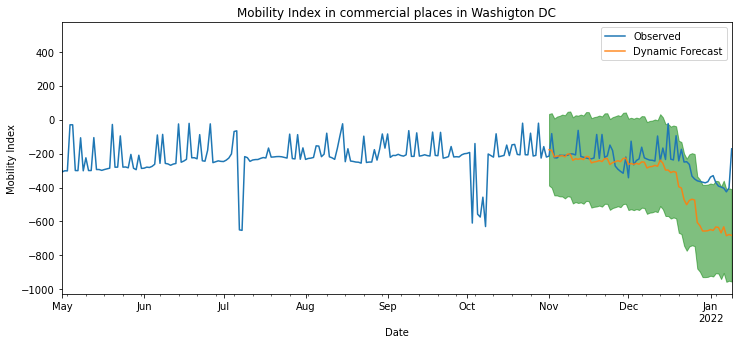

In [31]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 12, 5


# Plot observed values
ax = all_diff0[0]['commercial'].plot(label='Observed')

# Plot predicted values
predict0[0]['predicted_mean'].plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(predict0[0].index,
                predict0[0]['lower commercial'],
                predict0[0]['upper commercial'], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mobility Index')
ax.set_title('Mobility Index in commercial places in Washigton DC')
plt.legend()
ax.set_xlim(['2021-05-01','2022-01-09'])

plt.show()

The model's forecast and observed data are close to each other until the middle of December 2021, and the model's prediction has separated from the observed time series. This is when the omicron variant spread, and the daily new cases hit the recode high. So, by feeding these recode high daily cases into the model, the model predicted that the mobility index dropped during January 2022. However, as most people are fully vaccinated, people kept going out to a restaurant, bars, and other stores.
The model capture too much of the negative relationship between COVID-19 new cases and people's mobility in stores, based on the early 2020 patterns. Yet, by 2022, many people will be fully vaccinated, they continue to go out.
This suggests that for future work, incorporating vaccination rates will adjust these changes of people's perception toward going out during pandemics.

# 4. Forecasting
I forecast the mobility index for 2021 for all counties. First, I fit the model into an entire sample. Using that model, I make an out-of-sample prediction. Since my model needs an exogenous variable (covid-19 new cases for the forecasting period), I input hypothetical numbers. I assumed that by the end of 2022, the COID-19 new cases would be 0.

### Fit the model on the complete dataset
First, I create a hypothetical series for the COVID-19 new cases. I assume that the new daily case will drop incrementally and reach zero at the end of 2022. Below, I create hypothetical numbers for this scenarios.

Since I have a covid_19 new cases data till Jan 15, 2022. I use the observed data for Feb 2021 to Jan15, 2022. And beyond Jan15, I feed the hypothetical data which is based on the optimistic assumption that the covid new cases incrementally drop and reaches zero by the end of 2022.

In [32]:
# Optimistic Senario = the new covid cases incrementally drop in the next 360 days and reaches zeto in a year. 

# Calculate for county in diff 0 
case2_diff0=[]

for i in range(len(diff0)):
    maxval = all_diff0[0]['new_case_count'][-1]
    case =[]
    for i in range(360):
        if i == 0:
            case.append(maxval)
        else:
            new = maxval - i*(maxval/360)
            case.append(new)
    case2_diff0.append(case)



# Calculate for county in diff1 
case2_diff1=[]

for i in range(len(diff1)):
    maxval = all_diff1[0]['new_case_count'][-1]
    case =[]
    for i in range(360):
        if i == 0:
            case.append(maxval)
        else:
            new = maxval - i*(maxval/360)
            case.append(new)
    case2_diff1.append(case)



Next, I fit the model on the complete dataset, feed the covid new cases data into the model, and and get a forecast for 2022 for each county. The following function is almost identical to the earlier fitprediction function with minor changes.



In [33]:


def fitforecast(data, zip_df, best_para, newcases):    
    """
    Input: complete train data, list of county ids, and exogenous data. 
    Output: predictions
    
    """
    
    # To store the prediction 
    prediction = []
  
    for df, name, newcase in zip(data, zip_df, newcases):
        
        # 1. Fit the training data into the model
        
        # Get the optimal parameter from the grid serach results        
        order = list(best_para.loc[best_para.name==name, 'pdq'].values)[0]
        seasonal_order = list(best_para.loc[best_para.name==name, 'pdqs'].values)[0]

        # Plug the optimal parameter values into a SARIMAX model
        sarimax = SARIMAX(df['commercial'],
                          exog=df['new_case_count'],
                          order=order,
                          seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
        
        # Fit the model and print results
        output = sarimax.fit()        
 
        # 2. Predict using the train data 
        
        # prediction period
        day = pd.date_range('2022-01-10','2023-01-04', freq='D')
         
        # Get forecast 360 steps ahead in future
        pred = output.get_forecast(steps=360, exog=newcase) # dynamic=True,
        
        # Get confidence intervals of forecasts
        pred_conf = pred.conf_int()
        
        # Store prediction and confirence interval in one data frame to store.
        df_pred = pd.DataFrame(pred.predicted_mean)  #, index=test[i].index
        df_conf = pd.DataFrame(pred_conf)  #, index=test[i].index
        df_forecast = pd.concat([df_conf,df_pred], axis=1)
        df_forecast.reset_index(inplace=True)
        df_forecast.drop(['index'], axis=1, inplace=True)
        df_forecast.index=day
        
        prediction.append(df_forecast )
        
    return prediction




Apply the function and get prediction.

In [34]:
# Forecast for the optimistic COVID-19 senario 

forecast0 = fitforecast(all_diff0, diff0, best_para_diff0, case2_diff0)
forecast1 = fitforecast(all_diff1, diff1, best_para_diff1, case2_diff1)


#### Rolling back differenced time series. 
Using invert_diff function created earlier, I roll back the differenced time series to its original scale. 

In [35]:
# Roll back the forecast 
forecast1_rolled = []
for df, df_pre, name in zip(all_orig1, forecast1, diff1):
    # apply invert difference function. 
    df_fc = invert_diff(df, df_pre)
    forecast1_rolled.append(df_fc)


####  Forecast for Washington DC county
Below shows a rising trend of mobility in 2022. 75% confidence level are very wide. 

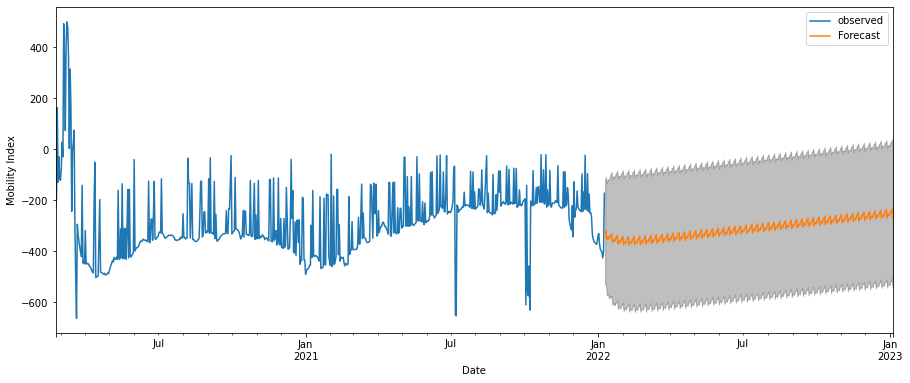

In [36]:
# Plot future predictions with confidence intervals
ax = all_diff0[0]['commercial'].plot(label='observed', figsize=(15, 6))
forecast0[0]['predicted_mean'].plot(ax=ax, label='Forecast')
ax.fill_between(forecast0[0].index,
                forecast0[0]['lower commercial'],
                forecast0[0]['upper commercial'], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Mobility Index')

plt.legend()
plt.show()

#### Lastly, I create a data frame that stores observed and forecast data for all counties in one table.

First, I create a data frame from a list that stores forecasted values for each county. A data frame's row is county fips, a column is a date, and each value is a predicted mobility index. Second, I create a data frame of the historical data in the same setting; row is county ID (countyfips), and column is the date. And merge two data frames using countyfips as a key value.


In [37]:
# 1. Convert a list of forecast into a table. 

# for county in diff1 
fc_df1=pd.DataFrame()
for df_pre, name in zip(forecast1, diff1):
    fc_df1[name]=forecast1[diff1.index(name)]['predicted_mean']

fd_merge1 = fc_df1.T

# for county in diff0 
fc_df=pd.DataFrame()

for df_pre, name in zip(forecast0, diff0):
    fc_df[name]=forecast0[diff0.index(name)]['predicted_mean']

fd_merge = fc_df.T

# merhe both dataset into one 
fd_merge2 = fd_merge.append(fd_merge1)

# 2. reshape a original dataset 
DF1 = DF
DF2 = DF1.unstack()['commercial']

DF2.reset_index(inplace=True)

In [38]:
# 3. merge the forecast df to original df

# reset index before merge 
fd_merge2.reset_index(inplace=True)

DF3 = DF2.merge(fd_merge2, how='left', left_on='countyfips', right_on='index')
DF3.head()

,countyfips,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,...,2022-12-26 00:00:00,2022-12-27 00:00:00,2022-12-28 00:00:00,2022-12-29 00:00:00,2022-12-30 00:00:00,2022-12-31 00:00:00,2023-01-01 00:00:00,2023-01-02 00:00:00,2023-01-03 00:00:00,2023-01-04 00:00:00
0,11001,-221.5,-193.0,164.0,-128.5,-28.5,-114.0,-121.5,-71.5,28.5,...,-246.575678,-236.231531,-268.186689,-255.970383,-256.346328,-259.745946,-245.375878,-244.153256,-233.809108,-265.764267
1,24009,-119.5,78.5,64.5,100.0,121.5,227.5,164.5,214.5,278.0,...,-61.052292,-72.679165,-60.345104,-73.343616,-97.116487,-128.314885,-139.519869,-118.165945,-129.792818,-117.458757
2,24017,214.0,200.0,257.0,286.0,145.0,386.0,436.0,514.0,607.0,...,-329.061800,-314.928219,-339.419910,-299.995843,-321.520414,-302.362307,-322.686701,-333.952349,-319.818768,-344.310460
3,24021,143.0,164.0,72.5,207.0,165.5,250.0,271.5,285.5,335.5,...,23.266463,72.294540,97.540600,57.213105,79.725521,52.207872,63.217456,28.850469,77.878546,103.124606
4,24031,-21.5,-2.0,-2.0,-2.0,43.0,141.5,21.5,285.5,78.5,...,-17.818357,-19.685219,21.230489,-7.092510,20.504769,1.604303,2.452482,-18.198357,-20.065218,20.850490


Finally, I transpose the data frame to columns = county, and rows = date, and save in csv.  

In [39]:
# Change countyfips from integer to string 

DF3.countyfips = DF3.countyfips.astype(str)


# set county fips as index 
DF3.set_index(DF3.countyfips,  inplace=True)
DF3.drop(['countyfips'], axis=1, inplace=True)

# Transform wide format to long format 
df3 = DF3.reset_index()
df3 = pd.melt(df3, id_vars=['countyfips'], var_name = 'date', value_name='mobility')

# calculate the changes. 
df3['yoy_change'] = df3.groupby(['countyfips'])['mobility'].pct_change(360)

# create new columns for post model analysis 
df3.date = df3.date.astype('str')
df3['year'] = df3.date.str[:4]
df3['month'] =df3.date.str[5:7]
df3['yearmonth']=df3.date.str[:7]
df3['day'] =df3.date.str[8:10]
df3['Date'] =df3.date.str[0:10]

In [40]:
df3.groupby(['yearmonth', 'countyfips']).mean()

mobility  yoy_change
yearmonth countyfips                          
2020-02   11001         -86.916667         NaN
          24009          78.750000         NaN
          24017         248.000000         NaN
          24021         167.000000         NaN
          24031          26.166667         NaN
...                            ...         ...
index     51153       51153.000000 -296.682081
          51187       51187.000000  -96.855805
          51510       51510.000000 -198.735125
          51610       51610.000000 -138.260638
          51683       51683.000000 -364.964789

[592 rows x 2 columns]

## Save data

In [41]:
# Save
df3.to_csv('Data/mobility_forecast_normal.csv', index=False)